In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path = '/content/drive/MyDrive/Fakenewsnet/BuzzFeed_real_news_content.csv'
fake_path = '/content/drive/MyDrive/Fakenewsnet/BuzzFeed_fake_news_content.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df])



Mounted at /content/drive


,title,label
0,BREAKING: Judge DEMANDS Release Of Clinton’s S...,0
1,Sacramento mayor punches pie thrower,1
2,Hillary’s TOP Donor Country Just Auctioned Off...,0
3,New York bomb Suspect SUED Police!,0
4,NYC Terrorist Ahmad Rahami Sued Police Departm...,0
...,...,...
177,"President Obama Vetoes 9/11 Victims Bill, Sett...",1
178,"“If You Can’t Run Your Own House, You Certainl...",0
179,Angela Merkel Admits Bringing In Muslim Refuge...,0
180,BOOM! Merkel Admits Flooding Germany With Musl...,0


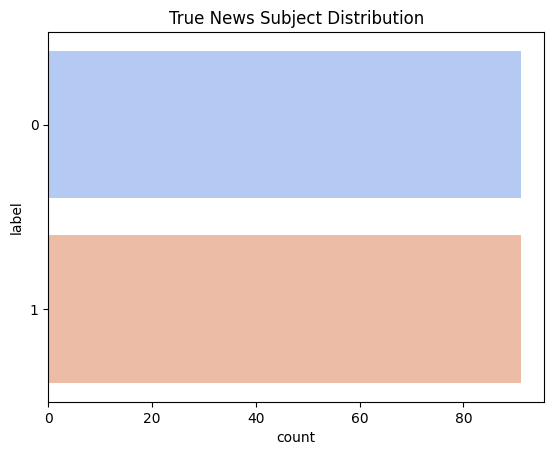

In [2]:
from sklearn.utils import shuffle

df = df[['title','label']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   182 non-null    object
 1   label   182 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [4]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   178 non-null    object
 1   label   178 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [7]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 178
Max length of the titles: 16
Mean length of the titles: 7.820224719101123
Median length of the titles: 8.0


In [8]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['title'])

sequences = tokenizer.texts_to_sequences(df['title'])
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
optimizer = Adam(lr=0.01)
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['label'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


In [11]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/10
3/3 [==============================] - 15s 545ms/step - loss: 0.6947 - accuracy: 0.4462 - val_loss: 0.6894 - val_accuracy: 0.6000
Epoch 2/10
3/3 [==============================] - 0s 31ms/step - loss: 0.6828 - accuracy: 0.5846 - val_loss: 0.6737 - val_accuracy: 0.6500
Epoch 3/10
3/3 [==============================] - 0s 31ms/step - loss: 0.6225 - accuracy: 0.7692 - val_loss: 0.6757 - val_accuracy: 0.6000
Epoch 4/10
3/3 [==============================] - 0s 24ms/step - loss: 0.4984 - accuracy: 0.8154 - val_loss: 0.6068 - val_accuracy: 0.6500
Epoch 5/10
3/3 [==============================] - 0s 23ms/step - loss: 0.3064 - accuracy: 0.8692 - val_loss: 0.8230 - val_accuracy: 0.5500
Epoch 6/10
3/3 [==============================] - 0s 22ms/step - loss: 0.1994 - accuracy: 0.9231 - val_loss: 1.4483 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 0s 24ms/step - loss: 0.1172 - accuracy: 0.9615 - val_loss: 1.5460 - val_accuracy: 0.6500
Epoch 8/10
3/3 [=========

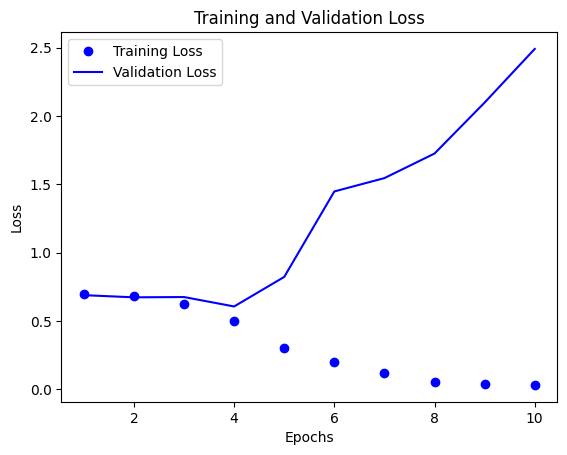

In [12]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 10)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 1s 47ms/step
CNN-BiLSTM Model Accuracy :  0.6944444444444444
Precision :  0.6470588235294118
Recall :  0.6875
F1 :  0.6666666666666667
G-mean: 0.6937218462755804
Training time:  16.156832456588745
Inference time:  0.9523239135742188
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.65      0.69      0.67        16

    accuracy                           0.69        36
   macro avg       0.69      0.69      0.69        36
weighted avg       0.70      0.69      0.70        36



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


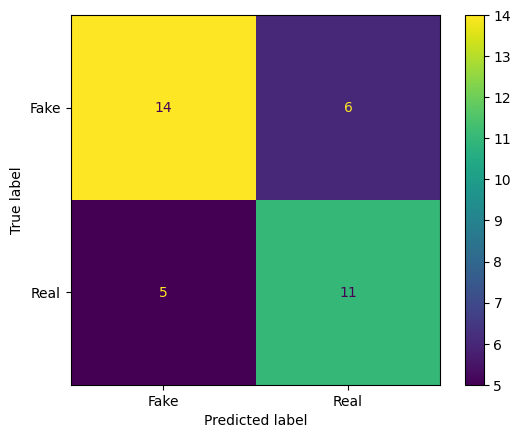

In [13]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()